In [1]:
from datasets import load_dataset

dataset = load_dataset("emotion")
label_names = dataset["train"].features["label"].names
num_labels = len(label_names)
print(label_names)


['sadness', 'joy', 'love', 'anger', 'fear', 'surprise']


In [2]:
import pandas as pd

dataset = load_dataset("emotion")
df = pd.DataFrame(dataset["train"])
df.head()


,text,label
0,i didnt feel humiliated,0
1,i can go from feeling so hopeless to so damned...,0
2,im grabbing a minute to post i feel greedy wrong,3
3,i am ever feeling nostalgic about the fireplac...,2
4,i am feeling grouchy,3


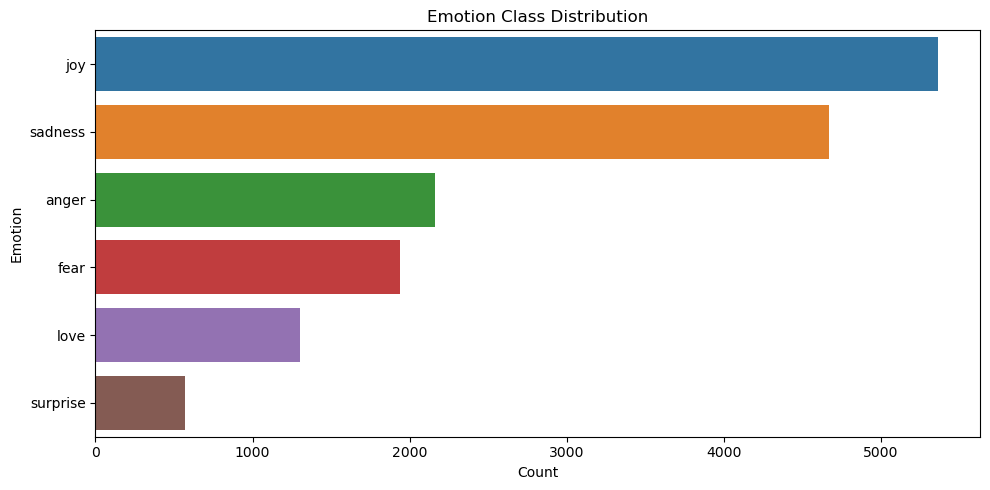

In [3]:
import matplotlib.pyplot as plt
import seaborn as sns

label_names = dataset["train"].features["label"].names
df["label_name"] = df["label"].apply(lambda x: label_names[x])

plt.figure(figsize=(10, 5))
sns.countplot(y="label_name", data=df, order=df["label_name"].value_counts().index)
plt.title("Emotion Class Distribution")
plt.xlabel("Count")
plt.ylabel("Emotion")
plt.tight_layout()
plt.show()


/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


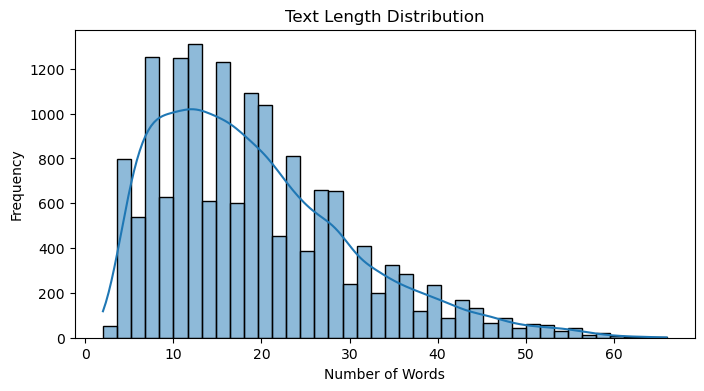

In [4]:
df["text_len"] = df["text"].apply(lambda x: len(x.split()))
plt.figure(figsize=(8, 4))
sns.histplot(df["text_len"], bins=40, kde=True)
plt.title("Text Length Distribution")
plt.xlabel("Number of Words")
plt.ylabel("Frequency")
plt.show()


In [5]:
for emotion in df["label_name"].unique():
    print(f"\n--- {emotion.upper()} ---")
    print(df[df["label_name"] == emotion]["text"].sample(3).values)



--- SADNESS ---
['i think i used to overeat i mean one reason anyway was because i wanted to make sure i didn t feel deprived later'
 'i literally just text tychelle to see if she wants to hang out because reading what i just wrote about my nonexistent social life made me feel so pathetic'
 'i am just feeling too rotten to put on a happy face for the night']

--- ANGER ---
['im inclined to believe that im simply too lazy to feel particularly greedy'
 'im supposed to be excited about my tattoo today but instead all im feeling is pissed off'
 'i feel all greedy']

--- LOVE ---
['i feel on the verge of tears from weariness i look at your sweet face and cant help but tenderly kiss your cheeks'
 'i wonder if he feels like i dont care about him when i stop caring about me'
 'i feel oddly nostalgic for those early days when we were all still figuring things out']

--- SURPRISE ---
['i remember feeling amazed'
 'i stared up at him amazed by the feeling and as equally amazed that nothing else 

In [6]:
from collections import Counter
import re

def clean_text(text):
    return re.sub(r"[^\w\s]", "", text.lower())

for emotion in df["label_name"].unique():
    texts = df[df["label_name"] == emotion]["text"].apply(clean_text)
    words = " ".join(texts).split()
    common = Counter(words).most_common(10)
    print(f"\n{emotion.upper()} → {common}")



SADNESS → [('i', 7635), ('feel', 3299), ('and', 2692), ('to', 2335), ('the', 2155), ('a', 1656), ('feeling', 1523), ('of', 1422), ('that', 1299), ('my', 1245)]

ANGER → [('i', 3576), ('feel', 1459), ('and', 1258), ('to', 1162), ('the', 1109), ('a', 791), ('feeling', 721), ('that', 705), ('of', 630), ('my', 573)]

LOVE → [('i', 2120), ('feel', 929), ('and', 902), ('to', 860), ('the', 780), ('a', 571), ('of', 482), ('that', 460), ('my', 399), ('feeling', 378)]

SURPRISE → [('i', 927), ('feel', 356), ('and', 354), ('the', 335), ('to', 267), ('a', 256), ('that', 212), ('feeling', 209), ('of', 191), ('my', 163)]

FEAR → [('i', 3083), ('feel', 1212), ('to', 1116), ('and', 1110), ('the', 1000), ('a', 806), ('feeling', 742), ('of', 614), ('that', 531), ('my', 525)]

JOY → [('i', 8518), ('feel', 3928), ('and', 3273), ('to', 3232), ('the', 2991), ('a', 2120), ('that', 1905), ('of', 1651), ('feeling', 1539), ('my', 1378)]


In [7]:
print("Total Samples:", len(df))
print("Unique Emotions:", df['label_name'].nunique())
print("Avg Words per Sample:", df['text_len'].mean())


Total Samples: 16000
Unique Emotions: 6
Avg Words per Sample: 19.1663125


In [8]:
df = pd.DataFrame(dataset["train"])
df["label_name"] = df["label"].apply(lambda x: label_names[x])

# Sample up to 1000 examples per class
balanced_df = df.groupby("label_name").apply(lambda x: x.sample(n=min(100, len(x)), random_state=42)).reset_index(drop=True)

# Convert back to Hugging Face Dataset
from datasets import Dataset
balanced_dataset = Dataset.from_pandas(balanced_df.drop(columns=["label_name"]))

In [9]:
len(balanced_df)

600

In [16]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification, Trainer, TrainingArguments
from sklearn.metrics import accuracy_score, f1_score
from datasets import DatasetDict
from sklearn.model_selection import train_test_split
import numpy as np
import torch

In [17]:
train_df, val_df = train_test_split(balanced_df, test_size=0.1, stratify=balanced_df["label"], random_state=42)

train_dataset = Dataset.from_pandas(train_df.drop(columns=["label_name"]))
val_dataset = Dataset.from_pandas(val_df.drop(columns=["label_name"]))

balanced_ds = DatasetDict({
    "train": train_dataset,
    "validation": val_dataset
})

# --------------------------------------
# 2. Tokenize the text
# --------------------------------------
tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased")

def tokenize(example):
    return tokenizer(example["text"], padding="max_length", truncation=True, max_length=128)

tokenized_ds = balanced_ds.map(tokenize, batched=True)
tokenized_ds = tokenized_ds.remove_columns(["text", "__index_level_0__"])
tokenized_ds.set_format("torch")


Map:   0%|          | 0/540 [00:00<?, ? examples/s]

Map:   0%|          | 0/60 [00:00<?, ? examples/s]

In [19]:
from transformers import AutoModelForSequenceClassification

model = AutoModelForSequenceClassification.from_pretrained(
    "distilbert-base-uncased",  # 👈 smaller model
    num_labels=num_labels
)

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [13]:
from transformers import TrainingArguments, Trainer
from sklearn.metrics import accuracy_score, f1_score
import numpy as np

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    preds = np.argmax(logits, axis=1)
    return {
        "accuracy": accuracy_score(labels, preds),
        "f1": f1_score(labels, preds, average="weighted")
    }

training_args = TrainingArguments(
    output_dir="./emotion-bert",
    eval_strategy="epoch",
    save_strategy="epoch",
    learning_rate=2e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=3,
    weight_decay=0.01,
    load_best_model_at_end=True,
    metric_for_best_model="f1"
)


In [20]:
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_ds["train"],
    eval_dataset=tokenized_ds["validation"],
    tokenizer=tokenizer,
    compute_metrics=compute_metrics
)
trainer.train()


/var/folders/lv/cffgmp6n0fn9p_b28j0ghpxh0000gn/T/ipykernel_1409/3034521569.py:1: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss,Accuracy,F1
1,No log,1.758240,0.283333,0.184219


ImportError: cannot import name 'DTensor' from 'torch.distributed.tensor' (/opt/anaconda3/lib/python3.11/site-packages/torch/distributed/tensor/__init__.py)